In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cbadc

# Generating Training Data

## Specify Analog Frontend

In [3]:
N = 6
M = N + 1
OSR = 10
BW = 1e6
T = 1.0 / (2 * BW * OSR)
k0 = 0.1
clock = cbadc.analog_signal.Clock(T)

In [4]:
analog_frontend = cbadc.synthesis.get_leap_frog(OSR=OSR, N=N, T=T)
Gamma = np.hstack(
        (
            analog_frontend.analog_system.Gamma[:,:1] * k0, 
            analog_frontend.analog_system.Gamma
        )
    )
# add dither control to analog frontend
analog_frontend = cbadc.analog_frontend.AnalogFrontend(
        cbadc.analog_system.AnalogSystem(
            analog_frontend.analog_system.A,
            analog_frontend.analog_system.B,
            analog_frontend.analog_system.CT,
            Gamma,
            analog_frontend.analog_system.Gamma_tildeT,
        ),
        cbadc.digital_control.DitherControl(
            1,
            cbadc.digital_control.DigitalControl(
                clock,
                N
            ),
        ),
    )


## Simulation Setup

In [5]:
DC_gain = 1e6
vdd_voltage = 1.2
training_simulation_size = 1 << 15
C_int = 1e-12

In [6]:
import cbadc.circuit

testbench_training = cbadc.circuit.testbench.OTATestBench(
    analog_frontend,
    [
        cbadc.analog_signal.Sinusoidal(
            0.0,
            0.0,
        ),
    ],
    clock,
    DC_gain,
    vdd_voltage=vdd_voltage,
    C_int=C_int,
)

amplitude = 1.0
frequency = 1.0 / T
while frequency > BW / 3:
    frequency /= 2.0

testbench_testing = cbadc.circuit.testbench.OTATestBench(
    analog_frontend,
    [
        cbadc.analog_signal.Sinusoidal(
            amplitude,
            frequency,
            phase = 0.0
        ),
    ],
    clock,
    DC_gain,
    vdd_voltage=vdd_voltage,
    C_int=C_int,
)

In [7]:
training_netlist = "train.cir"
training_raw = "train_blob"
ngspice_simulator = cbadc.circuit.simulator.NGSpiceSimulator(
    testbench_training,
    T,
    (training_simulation_size) * T,
    netlist_filename=training_netlist,
    raw_output_filename=training_raw,
)
ngspice_simulator.make_netlist()
ngspice_simulator.run()
ngspice_simulator.parse()


INFO:cbadc.circuit.simulator:['ngspice', '-b', '-r', 'train_blob', 'train.cir']


[Warning] Variable data type is detected as double precision.


### Extract control signals

In [8]:
training_control_signals_filename = "s_training.npy"
control_signals = np.zeros((training_simulation_size, M))
for index, s in enumerate(ngspice_simulator):
    control_signals[index, :] = s
np.save(training_control_signals_filename, control_signals)
print(control_signals)
print(f"control_signals: {control_signals.shape}")

[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 1. 1. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 1. 1. 0.]]
control_signals: (32768, 7)


### Extract state trajectories

In [9]:
_, data = ngspice_simulator.get_state_trajectories()
time_vector_training = data[::100, 0]
states_training = data[::100, 1 : 1 + N].transpose()

## Initialize Filter

In [10]:
import scipy.signal
filter_filename = "filter.npy"
lower_cutoff = 0.9 * BW * T
upper_cutoff = 1.1 * BW * T
K = 1 << 10
h0 = -k0 * scipy.signal.firwin2(
    K,
    np.array(
        [
            0.0,
            lower_cutoff,
            upper_cutoff,
            1.0,
        ]
    ),
    np.array([1.0, 1.0, 0.0, 0.0]),
)
reference_filter = cbadc.digital_estimator.initial_filter(
        [h0],
        [int(K) for _ in range(M)],
        [0],
)
np.save(filter_filename, reference_filter)

### Calibrate

In [11]:
import subprocess
batch_size = 1 << 7
step_size = 3e-7
decay = 0.91
training_iterations = 1 << 23
train_estimate_filename = "train.npy"
subprocess.run(
    [
        "calib",
        "calibrate",
        "-i",
        training_control_signals_filename,
        "--batch-size",
        str(batch_size),
        "-f",
        filter_filename,
        "-s",
        str(step_size),
        "-d",
        str(decay),
        "--iterations",
        str(training_iterations),
        "-o",
        train_estimate_filename,
    ],
    capture_output=True,
)

CompletedProcess(args=['calib', 'calibrate', '-i', 's_training.npy', '--batch-size', '128', '-f', 'filter.npy', '-s', '3e-07', '-d', '0.91', '--iterations', '8388608', '-o', 'train.npy'], returncode=0, stdout=b'offset: 0\n', stderr=b'\x1b\x1b[\x1b2023-10-10T14:36:40Z \x1b\x1bINFO \x1b calib\x1b\x1b[38;5;8m]\x1b calibrate was called! with 8388608 iterations\n\x1b\x1b[\x1b2023-10-10T14:36:40Z \x1b\x1bINFO \x1b calib\x1b\x1b[38;5;8m]\x1b using symmetric dac waveform\n')

### Validate

### Simulate test data

In [12]:
test_netlist = "test.cir"
testing_raw = "test.raw"
testing_size = 1 << 15

ngspice_simulator = cbadc.circuit.simulator.NGSpiceSimulator(
    testbench_testing,
    T,
    (testing_size) * T,
    netlist_filename=test_netlist,
    raw_output_filename=testing_raw,
)
ngspice_simulator.make_netlist()
ngspice_simulator.run()
ngspice_simulator.parse()

INFO:cbadc.circuit.simulator:['ngspice', '-b', '-r', 'test.raw', 'test.cir']


[Warning] Variable data type is detected as double precision.


In [13]:
testing_control_signals_filename = "s_test.npy"
control_signals = np.zeros((testing_size, M))
for index, s in enumerate(ngspice_simulator):
    control_signals[index, :] = s
np.save(testing_control_signals_filename, control_signals)
print(control_signals)
print(f"control_signals: {control_signals.shape}")

[[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 1. 0.]]
control_signals: (32768, 7)


In [14]:
_, data = ngspice_simulator.get_state_trajectories()
time_vector_testing = data[::100, 0]
states_testing = data[::100, 1 : 1 + N].transpose()

### Run Filter

In [15]:
test_estimate = "test.npy"
subprocess.run(
    [
        "calib",
        "validate",
        "-i",
        testing_control_signals_filename,
        "-f",
        filter_filename,
        "-o",
        test_estimate,
    ]
)
u_hat = np.load(test_estimate)

offset: -0.00011452689287522532


[2023-10-10T14:38:13Z INFO  calib] validate was called!
[2023-10-10T14:38:13Z INFO  calib] using symmetric dac waveform


## Plot results

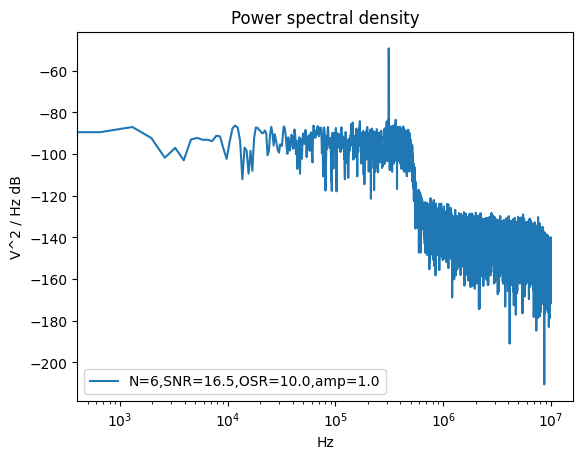

In [18]:
f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat[K :],
    fs=1 / T,
    nperseg=testing_size - K,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[signal_index] = False
noise_index[f < (BW * 1e-2)] = False
noise_index[f > BW] = False
fom = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=1 / T
)
est_SNR = cbadc.fom.snr_to_dB(fom["snr"])
est_ENOB = cbadc.fom.snr_to_enob(est_SNR)

psd_plot = plt.figure()
psd_axis = psd_plot.add_subplot(111)
psd_axis.set_title("Power spectral density")
psd_axis.set_xlabel("Hz")
psd_axis.set_ylabel("V^2 / Hz dB")

psd_axis.semilogx(
    f,
    10 * np.log10(np.abs(psd)),
    label=f"N={N},SNR={est_SNR:.1f},OSR={OSR:.1f},amp={amplitude:.1f}",
)

psd_axis.legend(loc="lower left")

In [19]:
from calib_python import plot_impulse_response, bode_plot, plot_state_dist
filter_coeffs = np.load(filter_filename)
plot_impulse_response(filter_coeffs, "imp.png")
bode_plot(filter_coeffs, "bode.png")

/workspaces/simulate_in_docker/calib_python.py:236: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(np.abs(h_freq)),


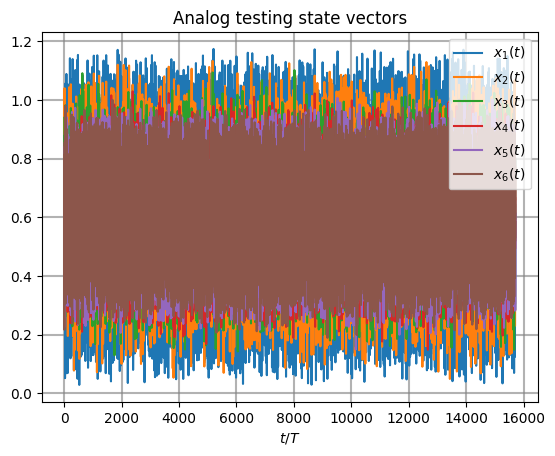

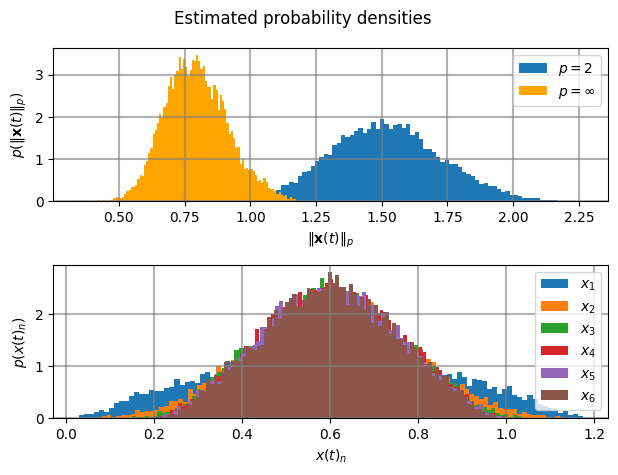

In [20]:
plt.figure()
plt.title("Analog testing state vectors")
for index in range(N):
    plt.plot(
        # res.res["state"]["time_vector"],
        states_testing[index, :],
        label="$x_{" + f"{index + 1}" + "}(t)$",
    )
plt.grid(visible=True, which="major", color="gray", alpha=0.6, lw=1.5)
plt.xlabel("$t/T$")
# plt.ylim(((-1, 1)))
# plt.xlim((0, 10))
plt.legend()
plot_state_dist(states_testing, "testing_dist.png")



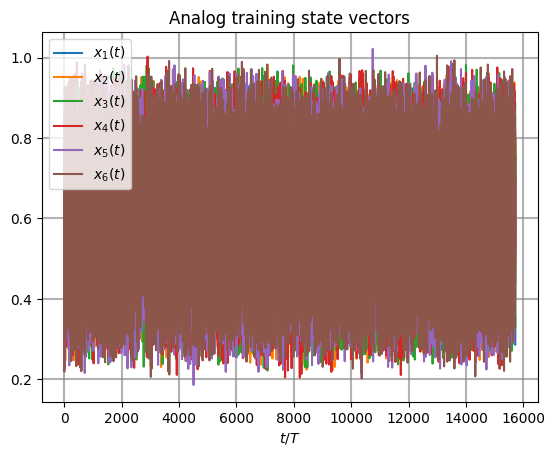

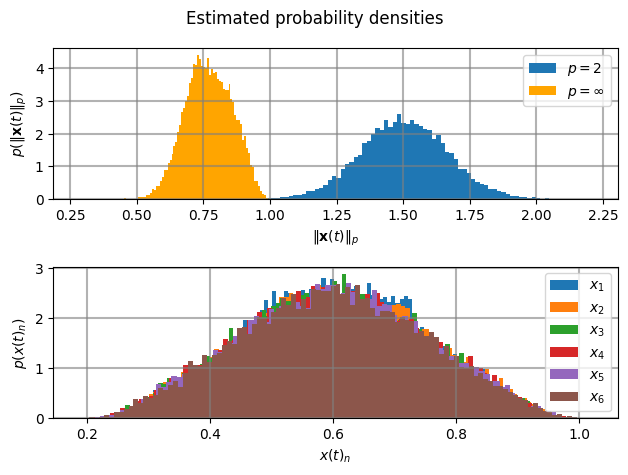

In [21]:
plt.figure()
plt.title("Analog training state vectors")
for index in range(N):
    plt.plot(
        # res.res["state"]["time_vector"],
        states_training[index, :],
        label="$x_{" + f"{index + 1}" + "}(t)$",
    )
plt.grid(visible=True, which="major", color="gray", alpha=0.6, lw=1.5)
plt.xlabel("$t/T$")
# plt.ylim(((-1, 1)))
# plt.xlim((0, 10))
plt.legend()
plot_state_dist(states_training, "training_dist.png")


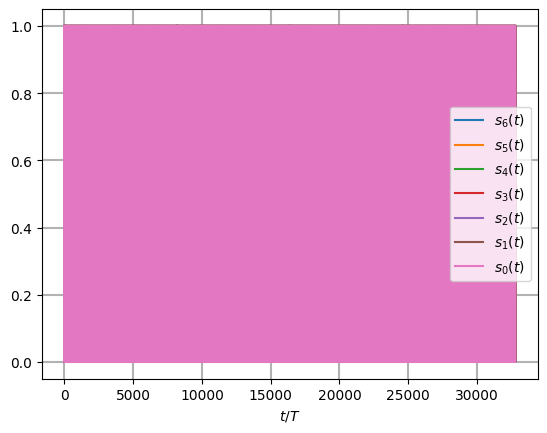

In [22]:
plt.figure()
for index in range(M)[::-1]:
    plt.plot(
        # res.res["state_training"]["time_vector"],
        control_signals[:, index],
        label="$s_{" + f"{index}" + "}(t)$",
    )
plt.grid(visible=True, which="major", color="gray", alpha=0.6, lw=1.5)
plt.xlabel("$t/T$")
# plt.ylim(((-1, 1)))
# plt.xlim((0, 10))
plt.legend()

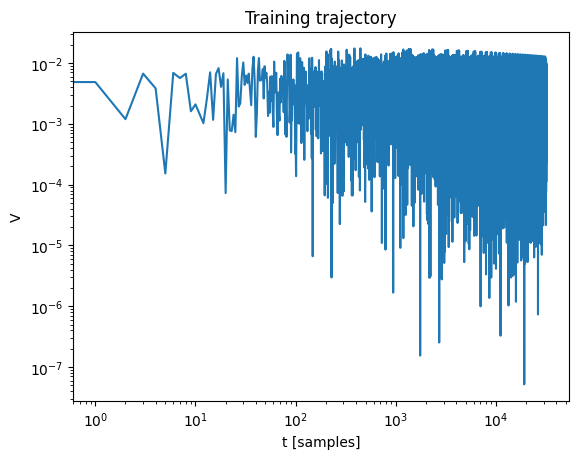

In [24]:
train_plot = plt.figure()
train_plot_axis = train_plot.add_subplot(111)
train_plot_axis.set_title("Training trajectory")
train_plot_axis.set_xlabel("t [samples]")
train_plot_axis.set_ylabel("V")

training_trajectory = np.load(train_estimate_filename)
train_plot_axis.loglog(np.abs(training_trajectory))

train_plot.savefig("train.png")

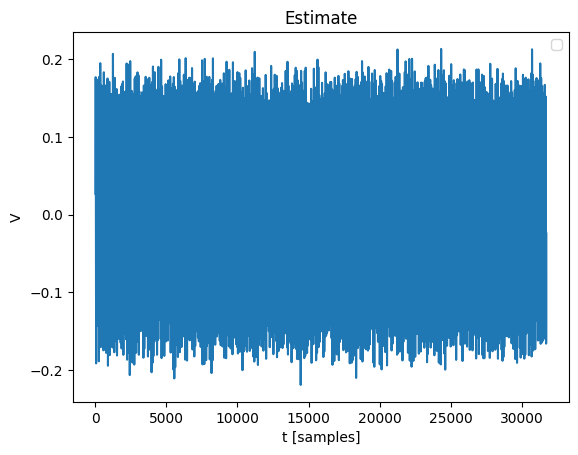

In [25]:
time_plot = plt.figure()
time_plot_axis = time_plot.add_subplot(111)
time_plot_axis.set_title("Estimate")
time_plot_axis.set_xlabel("t [samples]")
time_plot_axis.set_ylabel("V")

time_plot_axis.plot(u_hat)

time_plot_axis.legend()
time_plot.savefig("time.png")
